# Analysis of MEV rewards in ETH2

### Hello!
It's a useful thought exercise to think through the additional MEV rewards validators would get on top of their staking yield were they to run modified eth1 client software like Flashbots' MEV-Geth. Re-using the code from [this article](https://pintail.xyz/posts/beacon-chain-validator-rewards/) by Pintail, we can add additional considerations for MEV rewards using Flashbots data as a proxy for it.

These considerations have been added at the bottom here and stem from data collected by running an MEV-Geth node and analyzing Flashbots data from the public [mev-blocks API](https://blocks.flashbots.net).

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom

EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952

# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(no_of_validators): # mean
    return SECONDS_PER_YEAR / (12 * no_of_validators) # 12 seconds = 1 slot

# Accounting for probability of producing a block
def unluckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.01],31556952/12,1/no_of_validators)

def luckiest_one_percent_blocks_proposed(no_of_validators):
    return binom.ppf([0.99],31556952/12,1/no_of_validators)

avg_mev_reward_per_block = 0.18 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = 10e6 # 10M
validators_on_the_network_today = 122435 # april 22
block_selection_frequency_flashbots = 52 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles

### Factoring in tx_fees from EIP-1559

Assumptions:
- all PGA trading is now done through Flashbots

Numbers:
- 5% of Flashbots blocks are occupied by Flashbots bundles
   - using the public API blocks.flashbots.net
   - empirically, with bundle merging this will grow to XX%
- transaction fees activity over the last year from Etherscan
- gasnow.org max/med/min gas prices

1. Taking the remaining 95% of blockspace, we want to know the ratio of people who pay higher than execution gas price
2. For each block, we take the ratio between speed & normal
    - assuming these people
3. [ADD FURTHER DETAILS]




### Ideal case on infinite timescale
Let's consider first the case where:
* all validators participate perfectly and get the maximum reward they can get (i.e. $4*\text{base reward}$ - there is no slashing)
* all rewards are distributed evenly since every validator has an equal chance of being selected to produce a block, so on an infinite timescale rewards should even out.

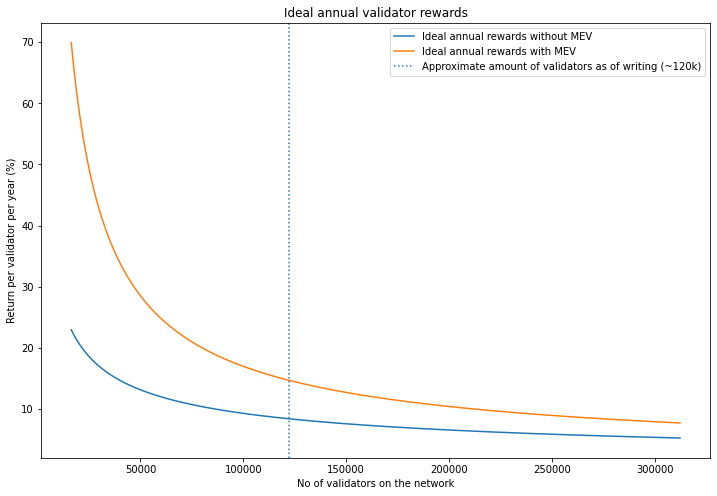

In [3]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) ) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Ideal annual validator rewards')
leg = ax.legend()

In [29]:
# tabulate returns for various amounts of validators with and without MEV
# setup an array of various # of possible active validators
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)  * (block_selection_frequency_flashbots/100))) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]
percentage_increase = []
for i in range(len(annual_yield)):
    percentage_increase.append((annual_yield_with_mev[i]/annual_yield[i]-1)*100)
data = {
    'n_validators': n_validators,
    'annual_reward (ETH)': ideal_reward,
    'annual_reward_with_mev (ETH)':ideal_reward_with_mev,
    'annual_yield (%)': annual_yield,
    'annual_yield_with_mev (%)': annual_yield_with_mev,
    'delta (%)': percentage_increase,
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('n_validators')

,annual_reward (ETH),annual_reward_with_mev (ETH),annual_yield (%),annual_yield_with_mev (%),percentage increase (%)
n_validators,,,,,
16384,7.35,22.37,22.97,69.92,204.39
50000,4.21,9.13,13.15,28.53,117.00
100000,2.98,5.44,9.30,16.99,82.73
120000,2.72,4.77,8.49,14.90,75.52
150000,2.43,4.07,7.59,12.72,67.55
200000,2.10,3.33,6.57,10.42,58.50
250000,1.88,2.87,5.88,8.96,52.32
300000,1.72,2.54,5.37,7.93,47.76
312500,1.68,2.47,5.26,7.72,46.80


At the current level of validators, we find that MEV can increase validator rewards by XX%, or give an implied yield of ZZ% rather than non-MEV yield of YY%. 
Going from estimates, by the end of the year if expect about 6m staked then validator could see their revenue increase by L%, giving an implied yield of W% rather than a non-MEV yield of Q%.

### ideal case on 1y timescale
Over any finite timescale, there will be variability in rewards, since some validators will be lucky and be given the opportunity to propose a greater than average number of blocks, and some unlucky, proposing fewer. 

We can find the distribution of luck for block proposal frequency in a year using the binomial distribution formula:
- every validator has an equal chance of being selected to propose each slot
    - if there are 100,000 validators then the chance of being selected to propose a slot is $10^{-5}$
- there are $\ 31556952 / 12 = 2629746$ slots per year. 


For 100,000 validators, this give us $$P(X) = {{2629746}\choose{k}} \cdot (10^{-5})^k{(1-10^{-5})}^{2629746-k}$$


// TODO: add binomial distribution graph for 100k validators

With 100,000 validators, the mean number of blocks proposed per validator per year is 26.30
- The unluckiest 1% of validators ($p(X) \leq 0.99)$ will have the opportunity to produce at most 15 blocks in a year.
- The median (average) validator ($p(X) = 0.5$) will have the opportunity to produce 26 blocks in a year
- The luckiest 1% of validators ($p(X) \geq 0.01$) will have the opportunity to produce at least 39 blocks in a year.

Repeating the same calculation for different numbers of validators, we obtain the table below:

In [9]:
# tabulate blocks proposed by unluckiest 1%, median, and luckiest 1% of validators over a year
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network

data = {
    'number of validators': n_validators,
    'unluckiest 1%': [(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators],
    'median':[(binom.ppf(0.5,31556952/12, 1/n)) for n in n_validators],
    'luckiest 1%': [(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('number of validators')

,unluckiest 1%,median,luckiest 1%
number of validators,,,
16384,132.00,160.00,191.00
50000,36.00,52.00,70.00
100000,15.00,26.00,39.00
120000,12.00,22.00,33.00
150000,9.00,17.00,28.00
200000,6.00,13.00,22.00
250000,4.00,10.00,19.00
300000,3.00,9.00,16.00
312500,3.00,8.00,16.00


Using these numbers, we can plot maximum validator rewards over a finite timescale and notice how a difference in luck influences what the luckiest 1% validators will make in a year, vs the unluckiest 1%.

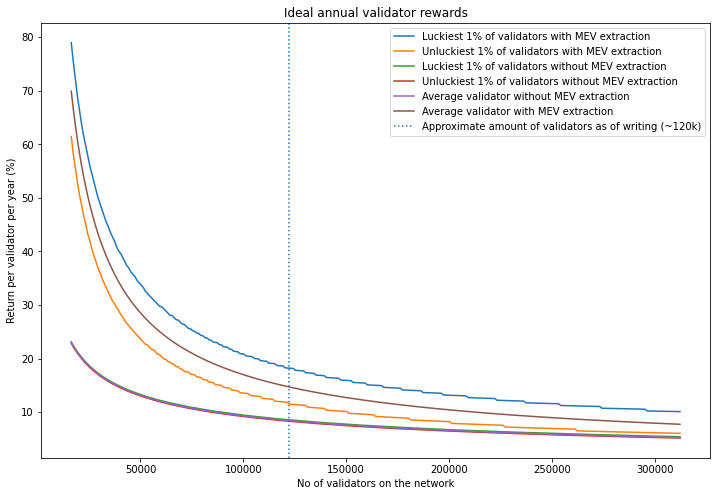

In [3]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], label='Average validator with MEV extraction')
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~120k)")
ax.set_title('Ideal annual validator rewards')
#ax.set_yscale("log")
leg = ax.legend();

### Perfect validator on an imperfect network 

Now that we've modelled the above, we can look into versions of the model that factor in slashing constraints. The first situation to model is a perfect validator on an imperfect network.

Validators get slashed not only for their own behavior but for the behaviour of others. Even if a validator behaves perfectly, other's behaviour may influence their reward. In particular, Pintail outlines two reasons perfect validators can get slashed:
- the accuracy reward is scaled by the proportion of active validators who voted the same way
- if an attestion of the perfect validator is included late because the block producer for the slot is offline, then the inclusion reward declines in inverse proportion to the inclusion delay.

These two cases have been modelled by Pintail in [the article](https://pintail.xyz/posts/beacon-chain-validator-rewards/), we use his model here.

**without MEV**

at P = 0.99, rewards fall by 0.89%

at P = 0.98, rewards fall by 1.78%

at P = 0.97, rewards fall by 2.68%

at P = 0.96, rewards fall by 3.57%

In [11]:
# plot reward for perfect validator in several participation level contexts

participation_rate = [1,0.99,0.98,0.97,0.96, 0.95]

n_validators = [n for n in range(50000,int(10e6)//32,1000)]
base_reward = [annualised_base_reward(n) for n in n_validators]


r_100000 = []
for P in participation_rate:
    accuracy_rewards = [P * 3 * r for r in base_reward]
    if P < 1:
        inclusion_reward = [(7/8) * r * P * math.log(P) / (P-1) for r in base_reward]
    else:
        inclusion_reward = [(7/8) * r for r in base_reward]
        
    block_reward = [(1/8) * r * P for r in base_reward]
    mev_reward = [avg_mev_reward_per_block * average_blocks_proposed_per_year(n)* (block_selection_frequency_flashbots/100) for n in n_validators]
    total_reward = [accuracy_rewards[i] + inclusion_reward[i] + block_reward[i] + mev_reward[i]
                    for i in range(len(block_reward))]
    r_100000.append(total_reward[50])
    

print(f'at P = {participation_rate[1]:.2f}, rewards fall by {100 * (1 - r_100000[1] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[2]:.2f}, rewards fall by {100 * (1 - r_100000[2] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[3]:.2f}, rewards fall by {100 * (1 - r_100000[3] / r_100000[0]):.2f}%')
print(f'at P = {participation_rate[4]:.2f}, rewards fall by {100 * (1 - r_100000[4] / r_100000[0]):.2f}%')

at P = 0.99, rewards fall by 0.49%
at P = 0.98, rewards fall by 0.98%
at P = 0.97, rewards fall by 1.46%
at P = 0.96, rewards fall by 1.95%


### imperfect validator on a perfect network

Now looking at an imperfect validator on a perfect network (ie. where our validator is the only one who goes offline), we can model how being offline affects a validator's revenue. Being offline causes 1) missing out some rewards, 2) penalties for missed attestations. Again, using Pintail's model we can find the minimum online time required in a year to receive a positive net reward.

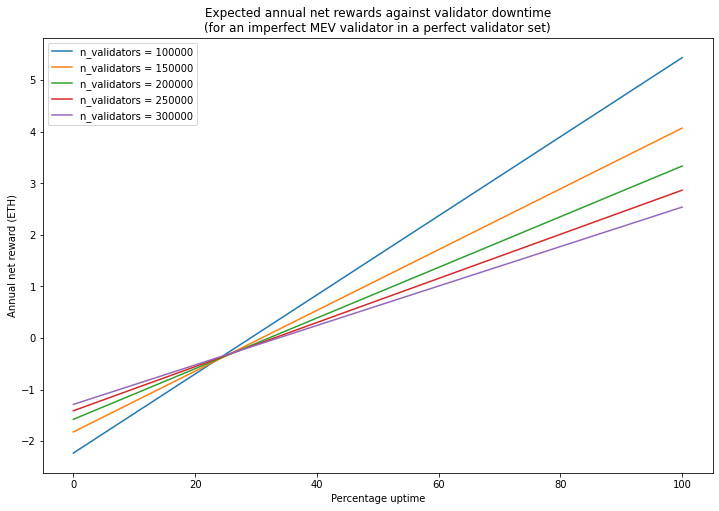

In [12]:
# Imperfect Validator on a Perfect Network

n_validators = [100000, 150000, 200000, 250000, 300000]
uptime = [i / 100 for i in range(101)]

fig, ax = plt.subplots(figsize=(12, 8))
for n in n_validators:
    base_reward = annualised_base_reward(n)
    mev_reward = average_blocks_proposed_per_year(n) * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100)
    net_reward = []
    for u in uptime:
        rewards = 4 * u * base_reward
        penalties = 3 * (1 - u) * base_reward
        mev_reward_adjusted_for_uptime = u * mev_reward
        net_reward.append(rewards - penalties + mev_reward_adjusted_for_uptime)

    ax.plot(range(101), net_reward, label=f'n_validators = {n}')

ax.set_xlabel('Percentage uptime')
ax.set_ylabel('Annual net reward (ETH)')
ax.set_title('Expected annual net rewards against validator downtime\n'
             '(for an imperfect MEV validator in a perfect validator set)')
leg = ax.legend()
#Skewed under 0 because we take average # of blocks proposed, need to repeat for luckiest/unluckiest 1%

The figure we find XX% is lower than the figure looking at validator rewards only, which is 43%.

### summary of findings

At the current number of ETH staked on the beacon chain ~4m:
1. validators stand to make an additional X eth per year from MEV revenue, or a XX% increase in average expected rewards, equivalent to an MEV-enabled XX% average annual staying yield vs ZZ% without MEV.
2. MEV rewards increase the inequality between luckiest and unluckiest validators.
3. MEV rewards imply a level of participation X% lower for the same returns as non-MEV rewards.
4. MEV rewards imply a minimum participation rate of ZZ% in order to breakeven, lower than the 43% found by Pintail.

Point #1 is a significant difference from the increase in miner revenue in the current system from mining Flashbots blocks rather than vanilla blocks, which is around 5%[^4]. On the bright side, this means MEV makes becoming a validator more attractive, which in turns means a larger set of validators and higher security for Ethereum. 

#### future model improvements
- better EIP-1559 numbers
- factoring in fee burn as being generally accretive to all ETH holders (including validators)
- even if all validators benefit from MEV extraction, does the uneveness of distribution of MEV within blocks disproportionaly favours large validators and still leads to oligopolic dynamics? 
    